# Basic Explorative Data Analysis
For the following conclusions we do assume that the present data set is complete (i.e., there has been no deliberate removal of data for the given time frame).

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
# Import data
data = pd.read_csv("data/raw_data/races.csv", sep=";")
data["race_created"] = pd.to_datetime(data["race_created"], dayfirst=True)

In [3]:
# Parameter
title_fontsize = 25
axis_fontsize = 20
legend_size = 20
tick_label_fontsize = 15

## 1 Time

### 1.1 Races
First we look at the number of races/games played vs time. This gives us a first feeling on how the data is distributed in time.

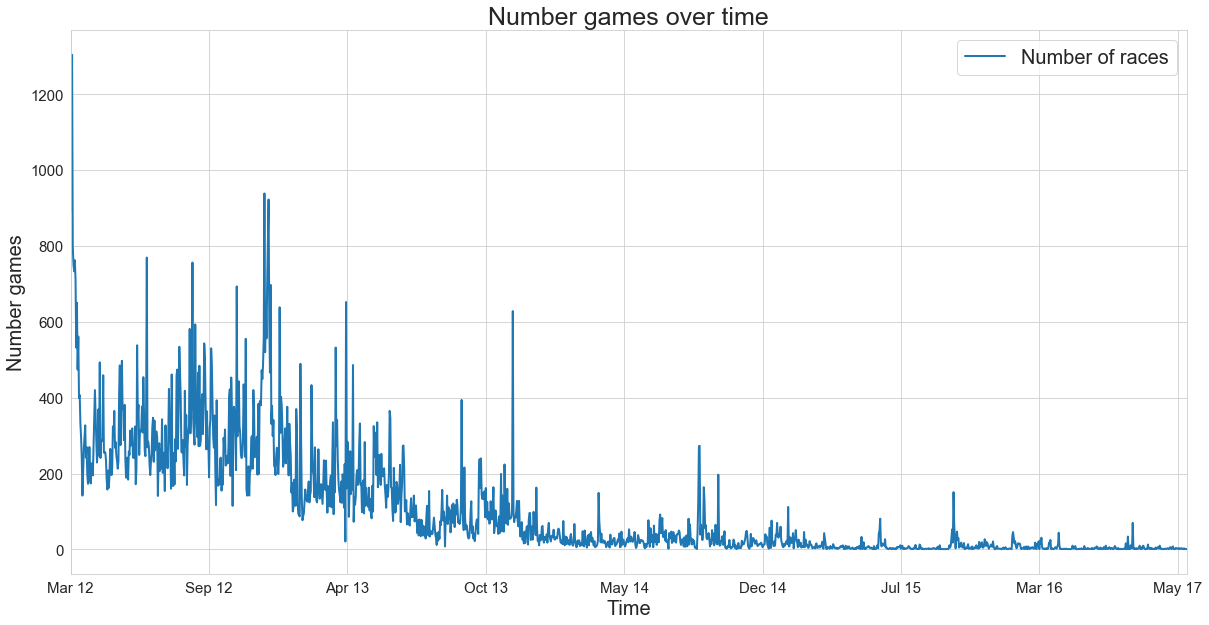

In [4]:
df_time = pd.DataFrame(data.groupby("race_created").count()).reset_index()
df_time.rename(columns={"id": "count"}, inplace=True)
df_time = df_time[["race_created", "count"]]

df_time["month"] = df_time["race_created"].dt.strftime("%b")
df_time["year"] = df_time["race_created"].dt.strftime("%y")
df_time["race_date"] = df_time["month"] +  " " + df_time["year"].astype("str")

fig, ax = plt.subplots(figsize=(20, 10))

df_time[["race_date","count"]].set_index("race_date").plot(ax=ax, lw=2, label="Number of races")
plt.title("Number games over time", fontsize=title_fontsize)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Number games", fontsize=axis_fontsize)
ax.tick_params(axis="both", which="major", labelsize=tick_label_fontsize)
ax.legend(labels = ["Number of races"], prop={"size": legend_size})

plt.show()

Apparently the peak of popularity was in the years 20xx to 20yy. Afterwards we see a drastic drop in games.

### 1.2 Players
# TODO: text anpassen! "curve" doof
Next we consider the amount of players. The curve follows quite similar the curve of number of races as one would expect.

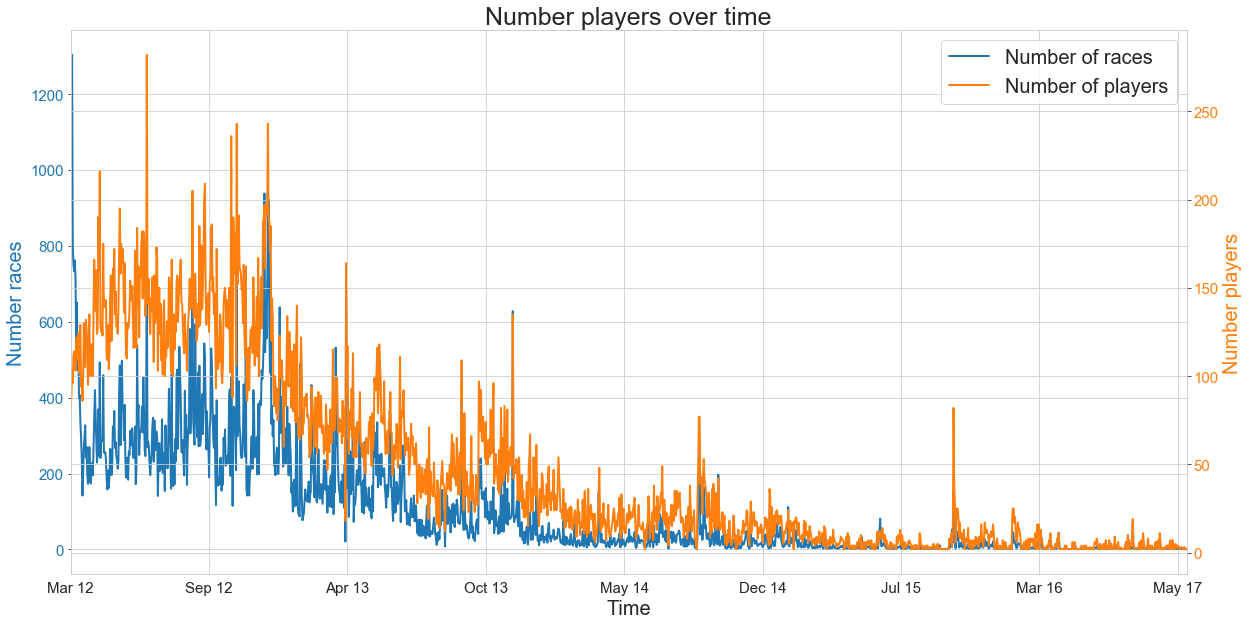

In [5]:
df_time["number_unique_players"] = data.groupby("race_created")["challenger", "opponent"].apply(lambda x: len(list(np.unique(x)))).values

fig, ax = plt.subplots(figsize=(20, 10))

race_plot = df_time[["race_date","count"]].set_index("race_date").plot(ax=ax, lw=2, label="Number of races", legend=False)
plt.title("Number players over time", fontsize=title_fontsize)
plt.xlabel("Time", fontsize=axis_fontsize)
ax.set_ylabel("Number races", fontsize=axis_fontsize, color="tab:blue")
ax.tick_params(axis="both", which="major", labelsize=tick_label_fontsize)
ax.tick_params(axis="y", labelcolor="tab:blue")

ax1 = ax.twinx()
player_plot = df_time[["race_date","number_unique_players"]].set_index("race_date").plot(ax=ax1, lw=2, label="Number of players", color="tab:orange", legend=False)
ax1.set_ylabel("Number players", fontsize=axis_fontsize, color="tab:orange")
ax1.tick_params(axis="y", which="major", labelsize=tick_label_fontsize, labelcolor="tab:orange")

handle_race, _ = ax.get_legend_handles_labels()
handle_player, _ = ax1.get_legend_handles_labels()
ax1.legend(handle_race + handle_player, ["Number of races", "Number of players"], prop={"size": legend_size})

plt.show()

### 1.3 Weekly distribution of races
As expected we see a higher activity of races/games played during weekends compared to week days.
TODO: Plot fehlt noch!

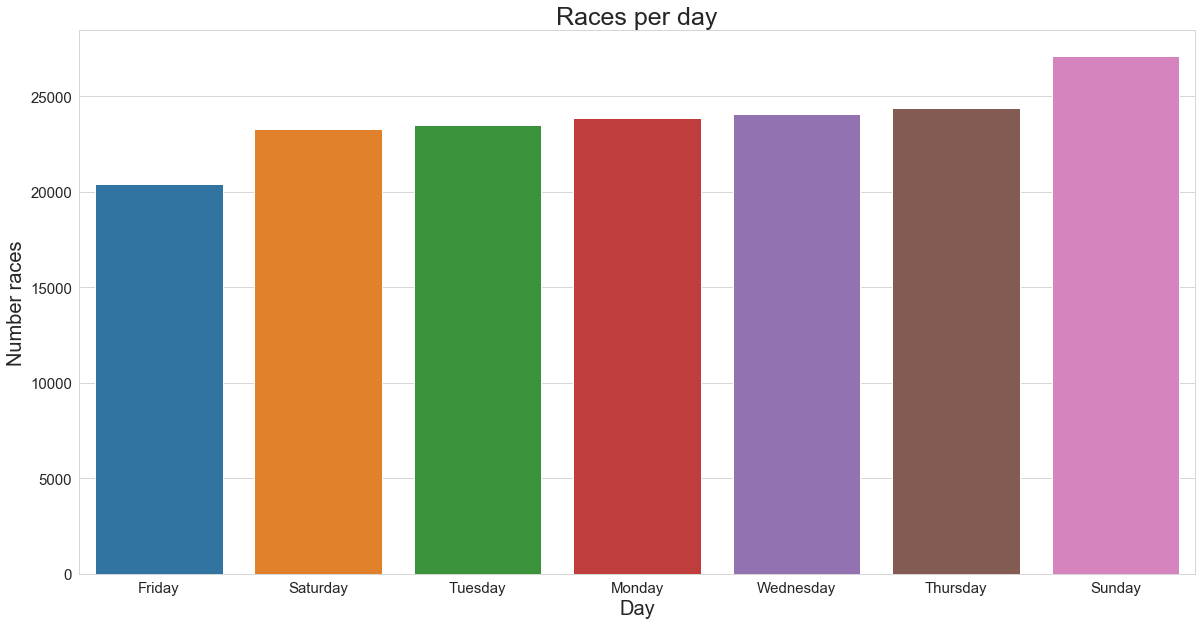

In [6]:
df_time["day"] = df_time["race_created"].dt.strftime("%A")

fig, ax = plt.subplots(figsize=(20, 10))

sns.barplot(x=df_time.groupby("day")["count"].sum().sort_values().index, y=df_time.groupby("day")["count"].sum().sort_values())
plt.title("Races per day", fontsize=title_fontsize)
plt.xlabel("Day", fontsize=axis_fontsize)
plt.ylabel("Number races", fontsize=axis_fontsize)
ax.tick_params(axis="both", which="major", labelsize=tick_label_fontsize)

plt.show()

sunday most prominent, interestingly friday and saturday least played

## 2 Players

### 2.1 Consistency
Are the available player ids sinnvoll? Yes, since there are no games where players played themselves

In [7]:
# Investigate Ids of opponents and challengers  TODO: output!?
len(data.loc[data.opponent==data.challenger])

0

### 2.2 Player Ids
Unklar was für text...

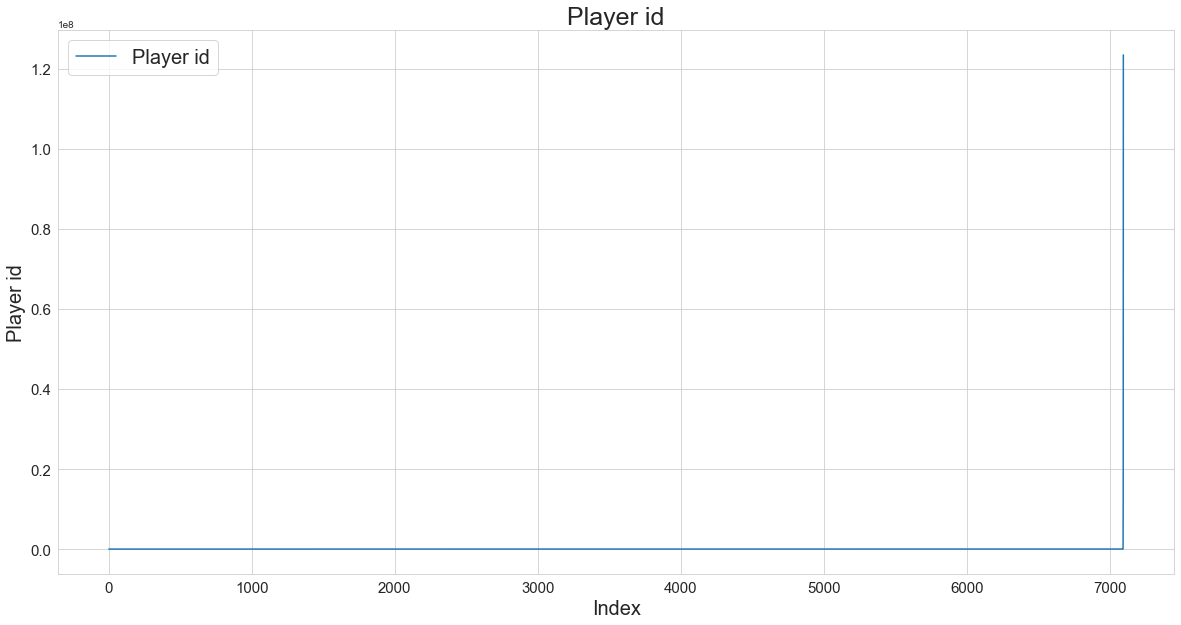

In [8]:
player_ids = list(pd.unique(data[["challenger", "opponent"]].values.ravel("K")))
player_ids.sort()

fig, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(x=range(len(player_ids)), y=player_ids, ax=ax)
plt.title("Player id", fontsize=title_fontsize)
plt.xlabel("Index", fontsize=axis_fontsize)
plt.ylabel("Player id", fontsize=axis_fontsize)
ax.tick_params(axis="both", which="major", labelsize=tick_label_fontsize)
ax.legend(labels = ["Player id"], prop={"size": legend_size})

plt.show()

Obviously something really fishy! Last values are extremely large... Let's take a closer look

In [9]:
print(player_ids[-3:])

[43000, 12345678, 123456789]


Obviously some unrealstic values, especially "1234567" and "12345678".-Nevertheless we check if they have actually driven any races:

In [10]:
print(data.loc[(data.opponent.isin(player_ids[-3:])) | (data.challenger.isin(player_ids[-3:]))].status.unique())

['retired' 'waiting']


Apparently not, so we simply remove it and get a much cleaner plot:

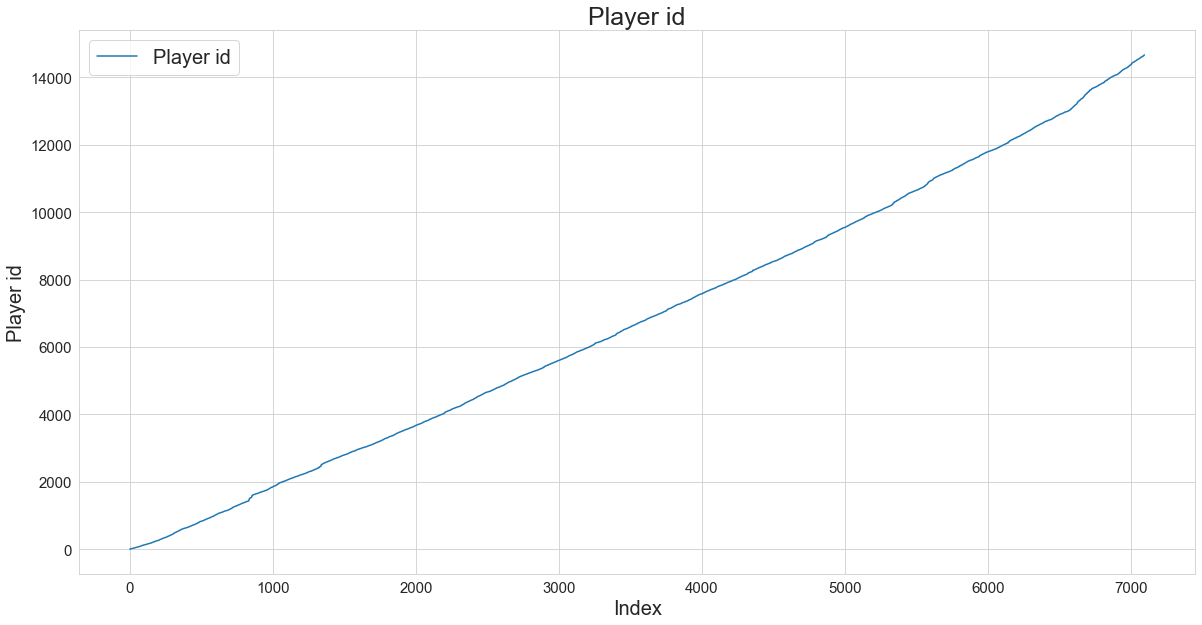

In [11]:
# remove duds
data.drop(data[data.opponent.isin(player_ids[-3:])].index, inplace=True)

# plot cleaned distribution
player_ids = list(pd.unique(data[["challenger", "opponent"]].values.ravel("K")))
player_ids.sort()

fig, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(x=range(len(player_ids)), y=player_ids, ax=ax)
plt.title("Player id", fontsize=title_fontsize)
plt.xlabel("Index", fontsize=axis_fontsize)
plt.ylabel("Player id", fontsize=axis_fontsize)
ax.tick_params(axis="both", which="major", labelsize=tick_label_fontsize)
ax.legend(labels = ["Player id"], prop={"size": legend_size})

plt.show()

# much better!

### 2.3 Multiplayer
How many players engage in multiplayer?

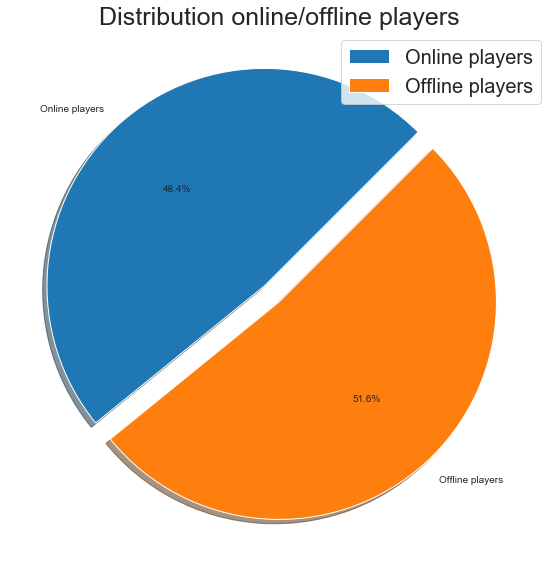

Number of total online players: 7094.
Number of total players: 14669.


In [12]:
# TODO: MAKE PLOT OUT OF THISplayer_ids
df_player = pd.DataFrame(data={"number_online_players": len(player_ids)/player_ids[-1], "number_offline_players": (player_ids[-1]-len(player_ids))/player_ids[-1]}, index=[0]).T
df_player.columns = ["fraction_players"]

fig, ax = plt.subplots(figsize=(10, 10))
df_player.plot.pie(y="fraction_players", explode=[.1, 0], labels=["Online players", "Offline players"], autopct="%1.1f%%",
                        shadow=True, startangle=45, ax=ax)
plt.title("Distribution online/offline players", fontsize=title_fontsize)
ax.legend(prop={"size": legend_size})
ax.set_ylabel("")
plt.show()

print(f"Number of total online players: {len(player_ids)}.\nNumber of total players: {player_ids[-1]}.")

Apparently only roughly xy% play online TODO!

### 2.4 Player activity
What is the activity of different players? How many games per players

In [13]:
# TODO: wie lade ich diese info?

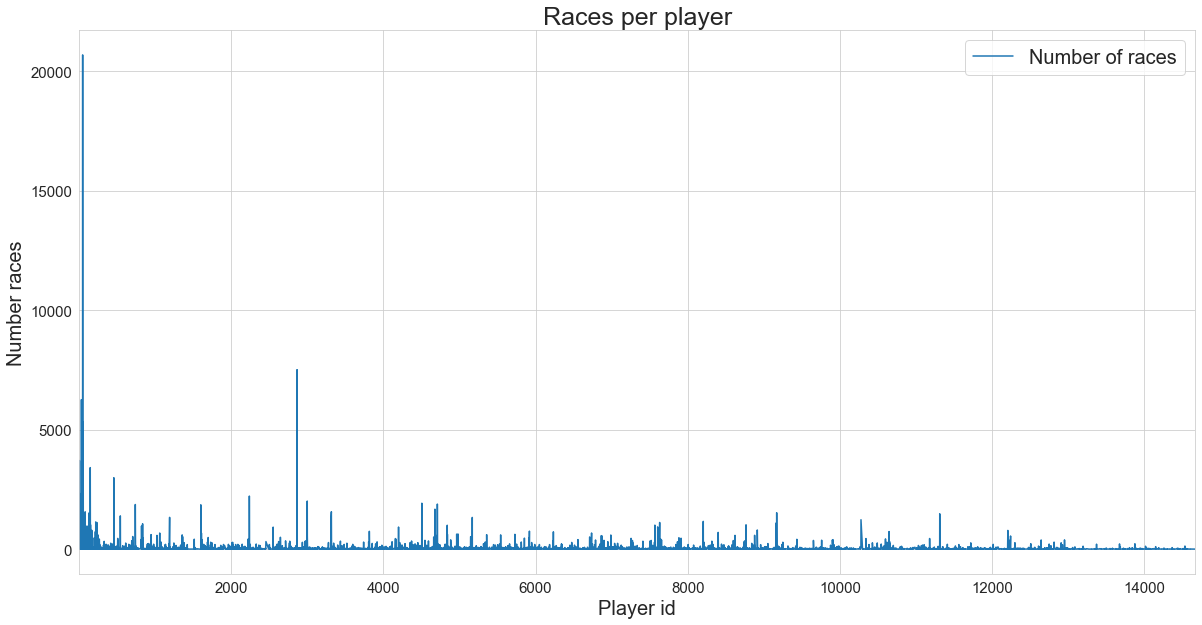

In [14]:
df_player = pd.DataFrame(data.groupby("challenger").count()).reset_index()
df_player.rename(columns={"id": "count", "challenger": "player"}, inplace=True)
df_player = df_player[["player", "count"]]
df_player
df_opponent = pd.DataFrame(data.groupby("opponent").count()).reset_index()
df_opponent.rename(columns={"id": "count", "opponent": "player"}, inplace=True)
df_opponent = df_opponent[["player", "count"]]
df_opponent
df_player = df_player.append(df_opponent).groupby("player").sum()
df_player = df_player.iloc[1:]  # remove first because that is when no race happened

fig, ax = plt.subplots(figsize=(20, 10))

df_player.plot(ax=ax)
plt.title("Races per player", fontsize=title_fontsize)
plt.xlabel("Player id", fontsize=axis_fontsize)
plt.ylabel("Number races", fontsize=axis_fontsize)
ax.tick_params(axis="both", which="major", labelsize=tick_label_fontsize)
ax.legend(["Number of races"], prop={"size": legend_size})

# TODO: plot anpassen! Title etc
plt.show()


we find that user XY did over 20000 races!

#### 2.5 Graph Kram
#### 2.5 Graph Kram
LAKSAN?!

## 3 Race
Here we are interested in properties of races. REIHENFOLGE VIELLEICHT ÄNDERN!

### 3.1 Status
Which races are actual driven, how is the distribution? Apparently many not even started etc. TODO text!

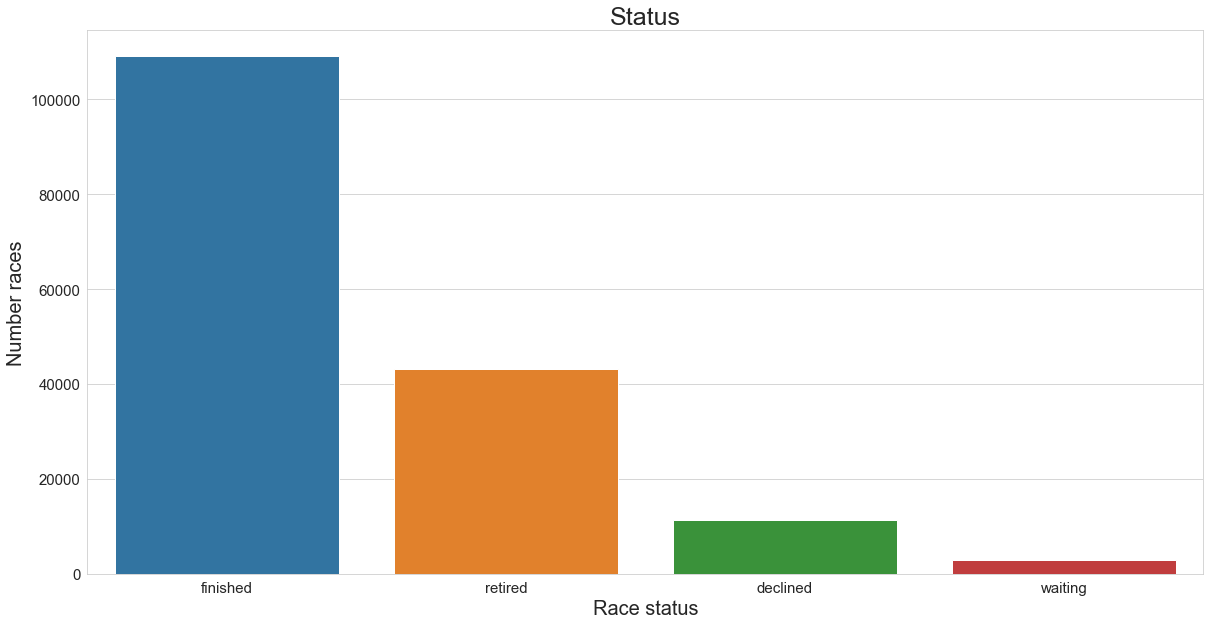

In [118]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.barplot(x=data["status"].value_counts().index, y=data["status"].value_counts().values, ax=ax)
plt.title("Status", fontsize=title_fontsize)
plt.xlabel("Race status", fontsize=axis_fontsize)
plt.ylabel("Number races", fontsize=axis_fontsize)
ax.tick_params(axis="both", which="major", labelsize=tick_label_fontsize)

plt.show()

### 3.1 Track
How popular are the different tracks?

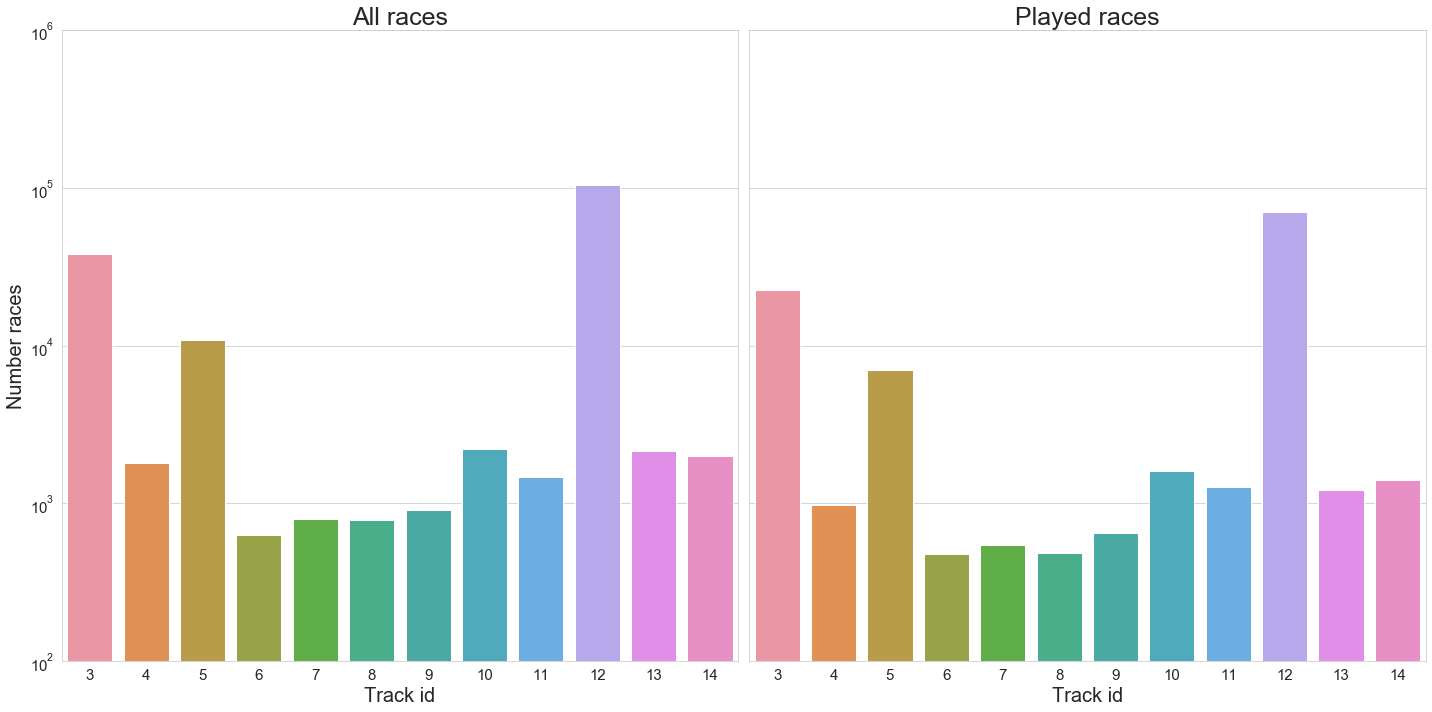

In [169]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

# All races
sns.barplot(x=data["track_id"].unique(), y=data["track_id"].value_counts(), ax=ax[0])
ax[0].set_title("All races", fontsize=title_fontsize)
ax[0].set_xlabel("Track id", fontsize=axis_fontsize)
ax[0].set_ylabel("Number races", fontsize=axis_fontsize)
ax[0].tick_params(axis="both", which="major", labelsize=tick_label_fontsize)
ax[0].set_yscale("log")

# Subset of "finished" races
sns.barplot(x=data.loc[data.status=="finished", "track_id"].unique(), y=data.loc[data.status=="finished", "track_id"].value_counts(), ax=ax[1])
ax[1].set_title("Played races", fontsize=title_fontsize)
ax[1].set_xlabel("Track id", fontsize=axis_fontsize)
ax[1].set_ylabel("")
ax[1].tick_params(axis="both", which="major", labelsize=tick_label_fontsize)
ax[1].set_yscale("log")

plt.setp(ax, ylim=(10**2, 10**6))
fig.tight_layout()
plt.show()

TODO: text how different if filtered!

### 3.3 Money
show figure with value counts, mostly small but some really large! maybe also dubs? not actual races anyway?

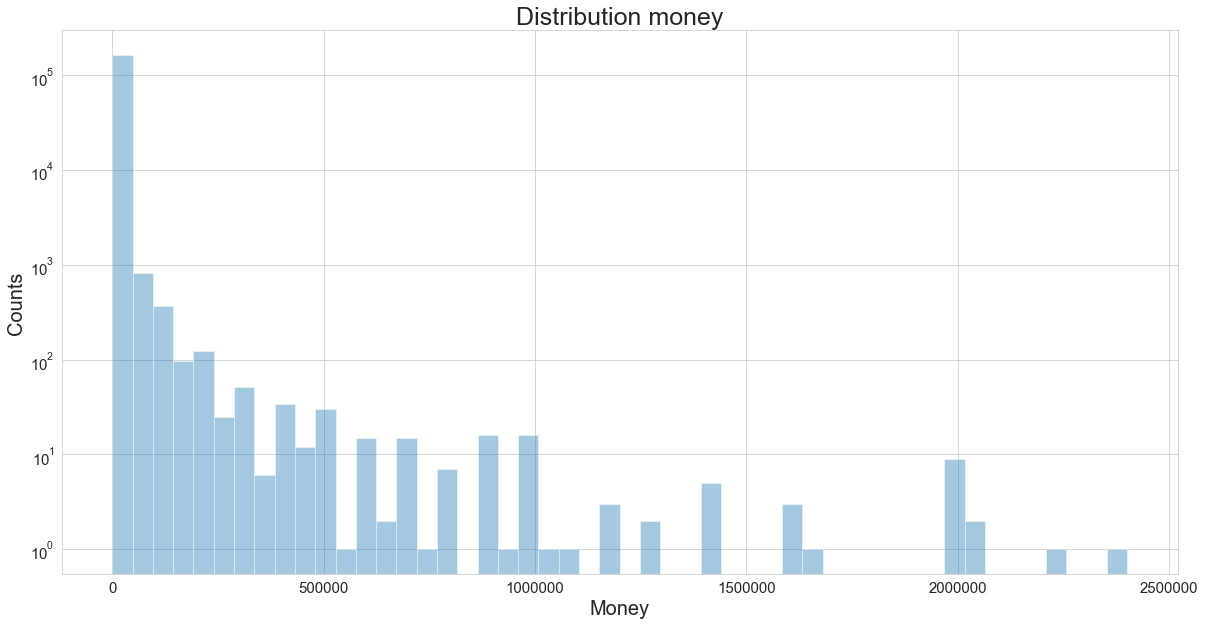

In [170]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.distplot(data["money"], kde=False)
plt.title("Distribution money", fontsize=title_fontsize)
plt.xlabel("Money", fontsize=axis_fontsize)
plt.ylabel("Counts", fontsize=axis_fontsize)
ax.tick_params(axis="both", which="major", labelsize=tick_label_fontsize)
ax.set_yscale("log")

plt.show()

### 3.4 Fuel consumption
show figure with value counts und viele komische -> wird extra behandelt

In [157]:
data["fuel_consumption"].value_counts()

4.425     26589
Apr 35    25523
0.375      6310
0.63       4149
2.529      1506
          ...  
9.097         1
37.715        1
57.375        1
6.018         1
0.49          1
Name: fuel_consumption, Length: 2825, dtype: int64

In [160]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166597 entries, 0 to 166608
Data columns (total 12 columns):
id                  166597 non-null int64
race_created        166597 non-null datetime64[ns]
race_driven         166597 non-null object
track_id            166597 non-null int64
challenger          166597 non-null int64
opponent            166597 non-null int64
money               166597 non-null int64
fuel_consumption    166597 non-null object
winner              166597 non-null int64
status              166597 non-null object
forecast            166597 non-null object
weather             109095 non-null object
dtypes: datetime64[ns](1), int64(6), object(5)
memory usage: 21.5+ MB


### 3.5 Weather
A lot of races didnt start at all therefore lot of nans, but otherwise mostly nice conditions

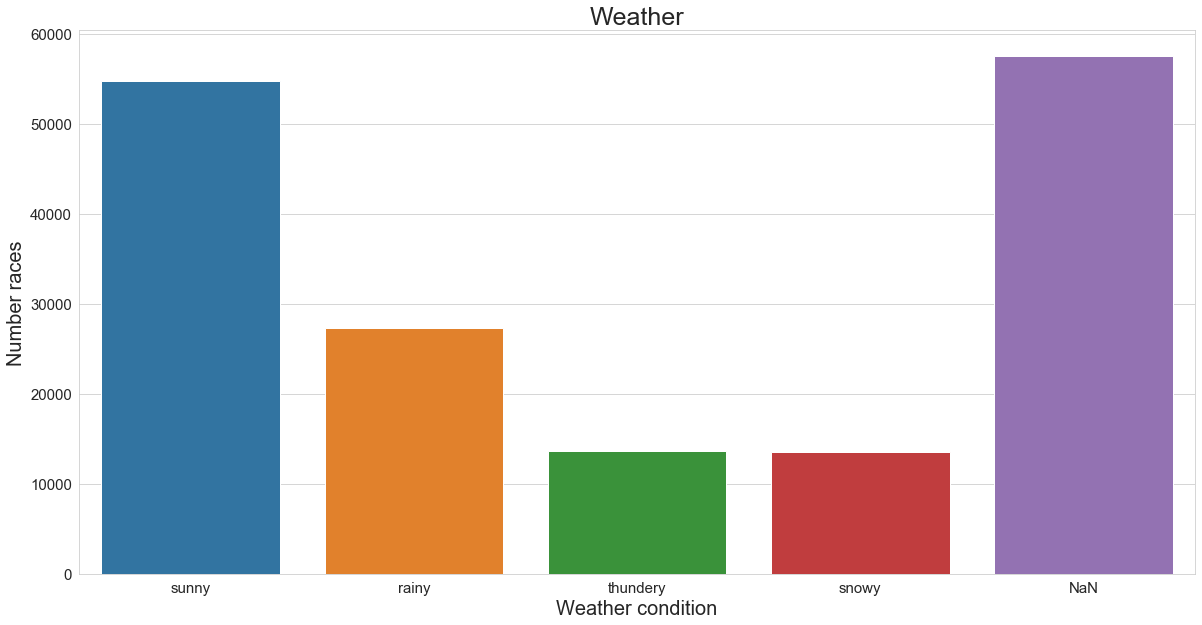

In [168]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.barplot(x=list(data["weather"].value_counts().index) + ["NaN"], y=list(data["weather"].value_counts().values) + [data["weather"].isna().sum()], ax=ax)
plt.title("Weather", fontsize=title_fontsize)
plt.xlabel("Weather condition", fontsize=axis_fontsize)
plt.ylabel("Number races", fontsize=axis_fontsize)
ax.tick_params(axis="both", which="major", labelsize=tick_label_fontsize)

plt.show()

# SUMMARY:
We need to clean data: translate dates into numerical and remove unrealistic players. this will be done at cleaning.py and afterwards we will do advanced eda and ML